In [286]:
# standard python modules
%matplotlib inline
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydataset
import seaborn as sns
from math import sqrt
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
import statsmodels.api as sm


# my modules
import src.env as env
import src.wrangle as wr
import src.evaluate as evaluate 

# setting random seed to 7
np.random.seed(7)

# turning off red warnings
import warnings
warnings.filterwarnings("ignore")

# module for fixing imported modules
from importlib import reload

In [191]:
df = wr.zillow_2017()

### Some Exploration

In [411]:
list(df.columns)

['tax_value', 'bedrooms', 'baths', 'sq_feet', 'fips']

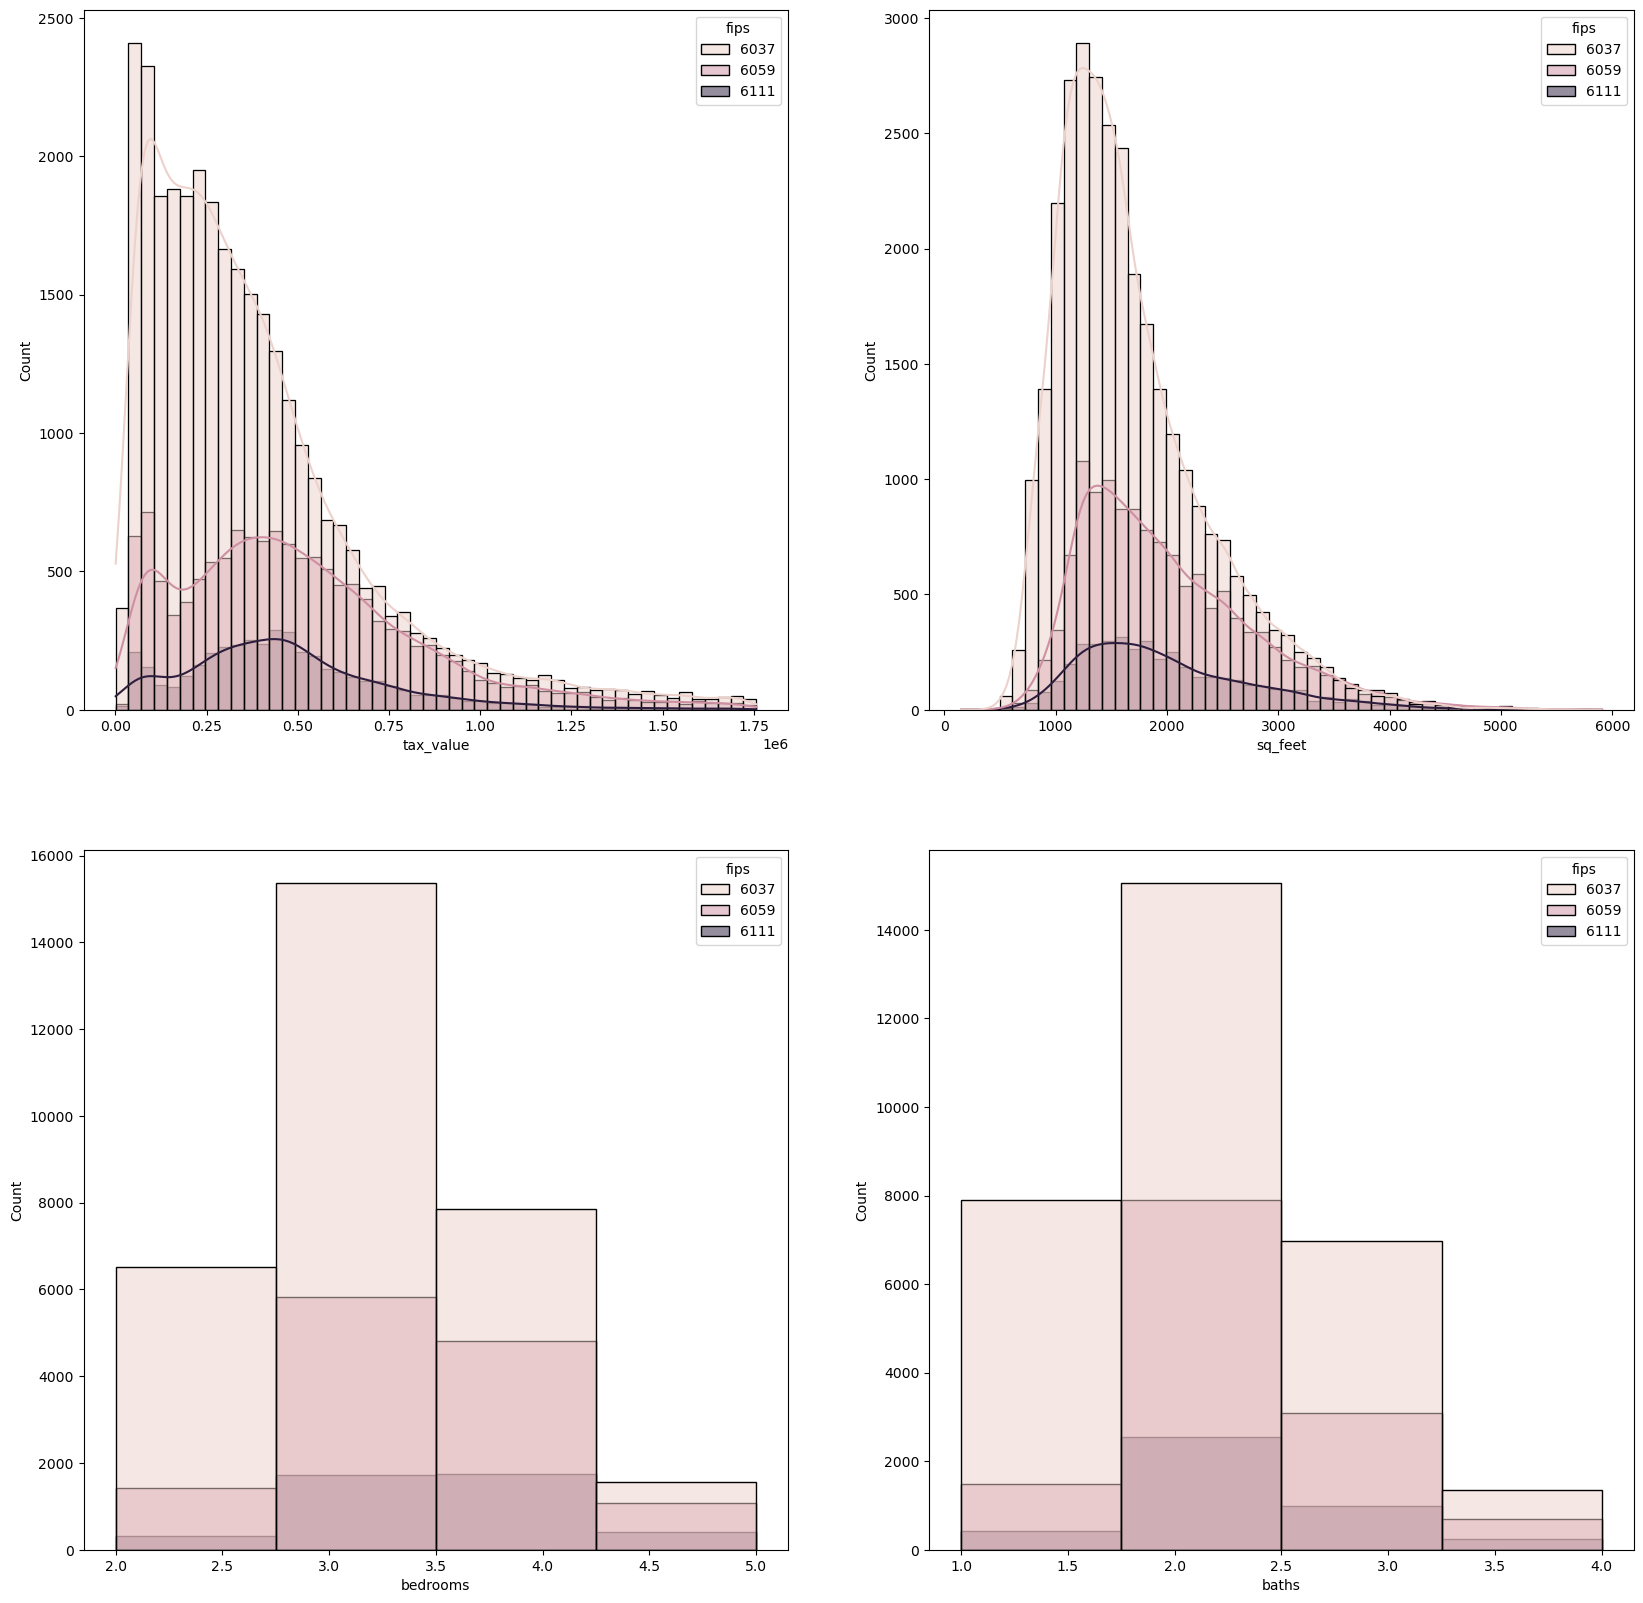

In [436]:
plt.figure(figsize=(20,20))
big_variables= ['tax_value','sq_feet']
small_variables= ['bedrooms','baths']

n =220
for i in big_variables:
    n+=1 
    plt.subplot(n)
    sns.histplot(data = df, x=i, hue='fips', kde = True, bins= 50)
    
for i in small_variables:
    n+=1 
    plt.subplot(n)
    sns.histplot(data = df, x=i, hue='fips', bins = 4)    
    

plt.show()

[]

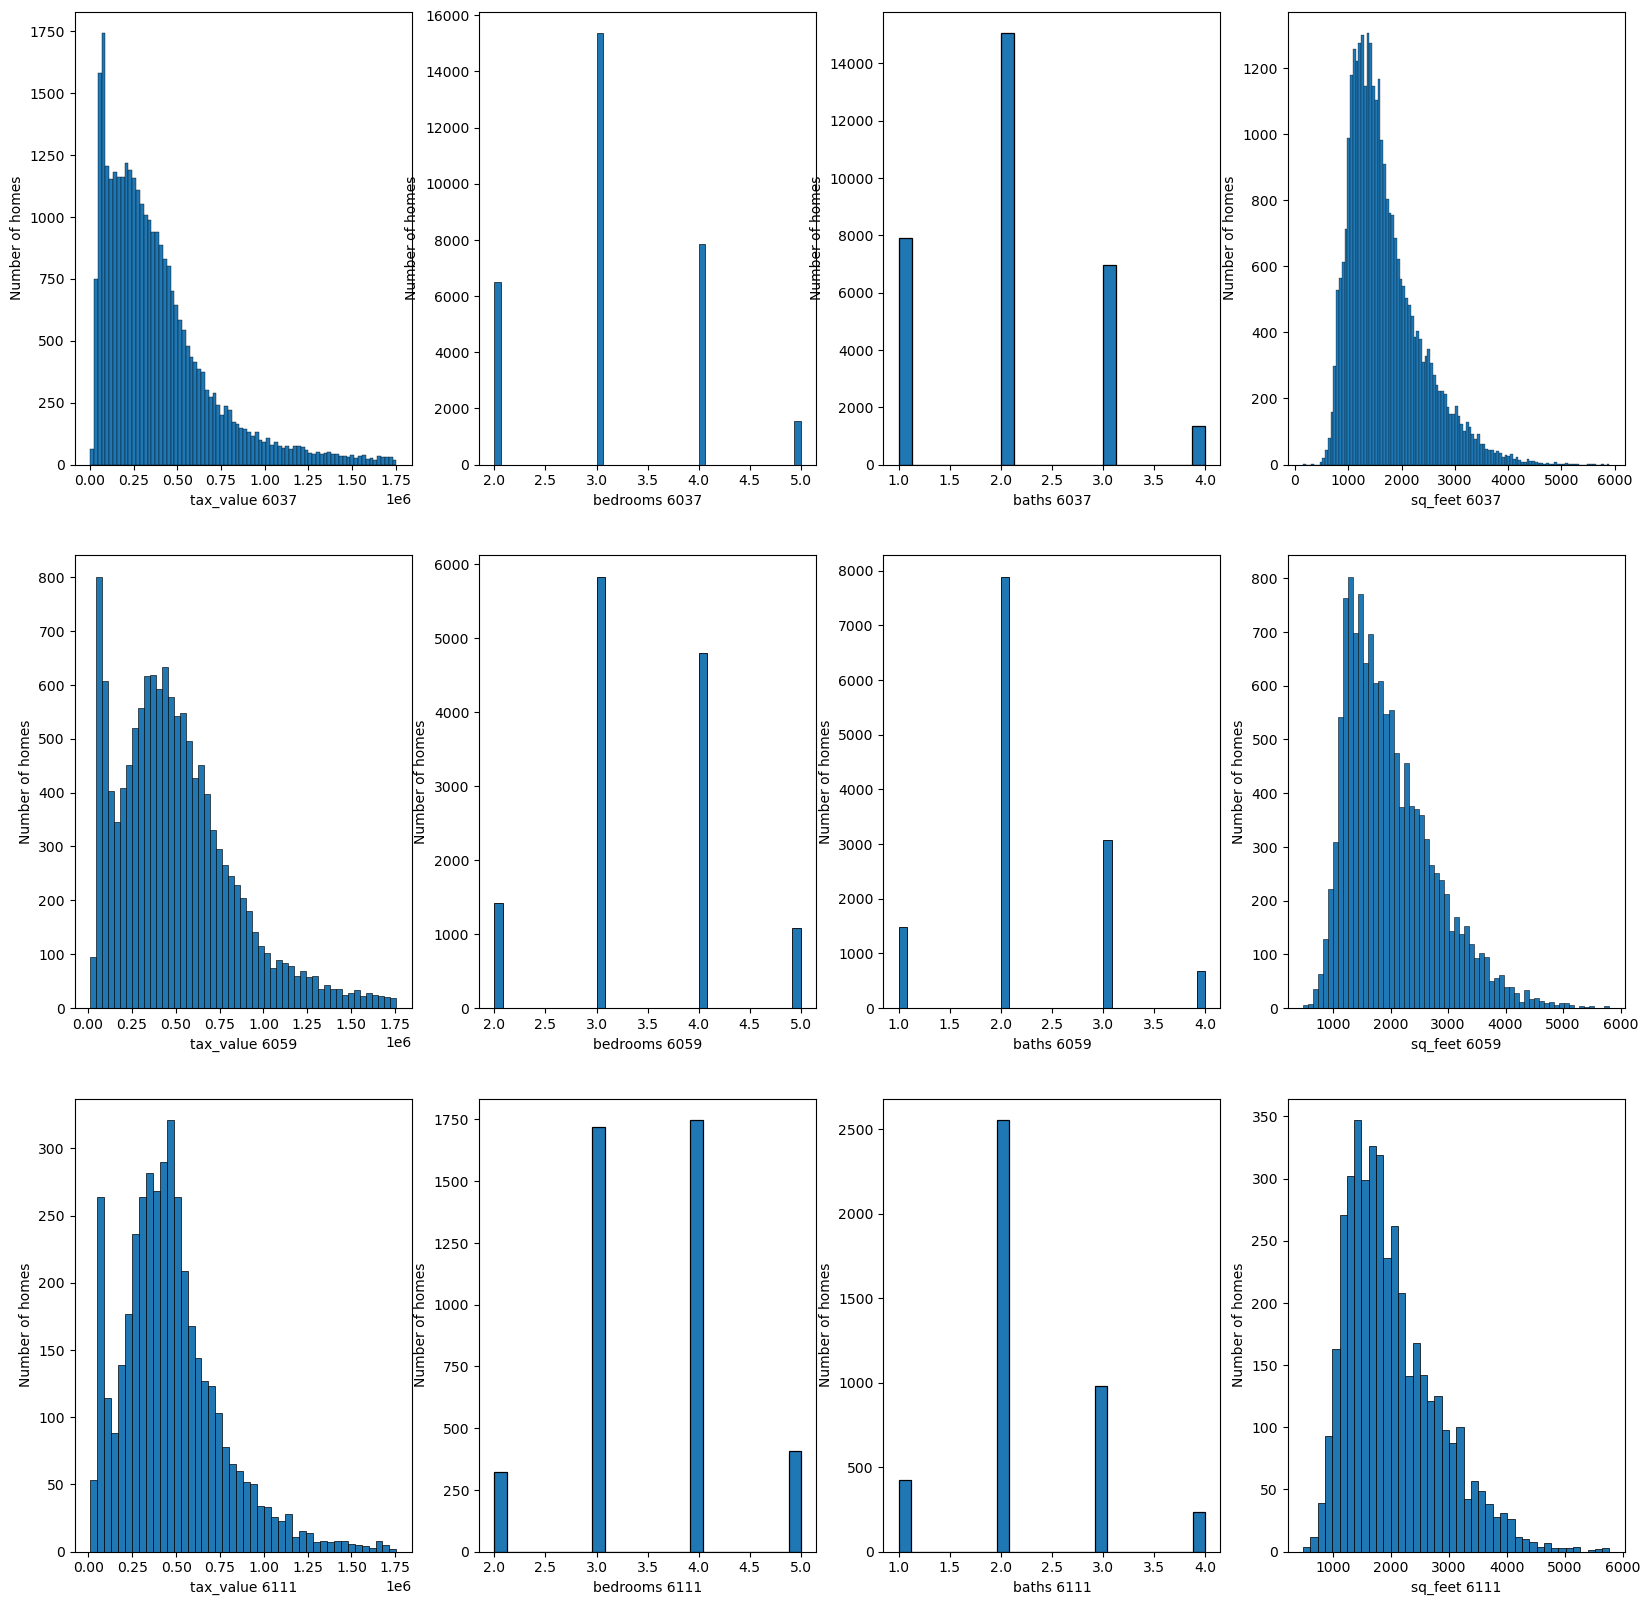

In [466]:
plt.figure(figsize = (20,20))

counties = (6037, 6059, 6111)
item = df['fips'] == 6037
variables = ['tax_value', 'bedrooms', 'baths', 'sq_feet']
booled_df = df[variables][item]

n = 1

for k in counties:
    item = df['fips'] == k
    booled_df = df[variables][item]
    
    
    for i in variables:

        plt.subplot(3,4,n)
        sns.histplot(data = booled_df, x=i, alpha=1)
        plt.xlabel(f'{i} {k}')
        plt.ylabel('Number of homes')
        n+=1 

    
#plt.subplots_adjust(hspace=0.5)
plt.plot()

### Fip / County information

- 6037 = Los Angeles County
- 6059 = Orange County 
- 6111 = Ventura County

### Separating Data into useful data frames

In [5]:
'''
Separating our big dataset by using boolean masks to identify our different counties

'''

keeper_variables = ['tax_value', 'bedrooms', 'baths', 'sq_feet']

county = df['fips'] == 6037
la_df = df[keeper_variables][county]

county = df['fips'] == 6059
orange_df = df[keeper_variables][county]

county = df['fips'] == 6111
ventura_df = df[keeper_variables][county]

In [6]:
(la_df.shape[0], orange_df.shape[0], ventura_df.shape[0], 
 la_df.shape[0]+ orange_df.shape[0]+ ventura_df.shape[0], df.shape[0])

(32791, 13671, 4314, 50776, 50776)

In [172]:
'''
Preparing to analyze our simple model as asked for initial evaluatation to be made upon
separating our data frames into train, validate and test data frames
further separates our data into our indepdendent and dependent variables
'''

# split data without differentiating counties
x_train, y_train, x_validate, y_validate, x_test, y_test = wr.x_y(better_df, 'tax_value')

# split la county dfs
la_x_train, la_y_train, la_x_validate, la_y_validate, la_x_test, la_y_test = wr.x_y(la_df, 'tax_value')

#split orange county dfs
or_x_train, or_y_train, or_x_validate, or_y_validate, or_x_test, or_y_test = wr.x_y(orange_df, 'tax_value')

# split ventura county dfs
vent_x_train, vent_y_train, vent_x_validate, vent_y_validate, vent_x_test, vent_y_test = wr.x_y(ventura_df, 'tax_value')

In [173]:
(la_y_test.shape[0],or_y_test.shape[0],vent_y_test.shape[0], 
la_y_test.shape[0]+or_y_test.shape[0]+vent_y_test.shape[0], y_test.shape[0])

(6559, 2735, 863, 10157, 9728)

### Creating results data frame for baseline, simple model and filling it

In [355]:
# creating dataframe to hold values for comparison between prediction models
predictions = pd.DataFrame()

# target column is the variable we are trying to predict with machine learning
predictions['target'] = y_train

# produce baseline predictions based on the mean of the tax values and median values
predictions['baseline_mean'] = round(y_train.mean(),3)
predictions['baseline_median'] = y_train.median()


In [356]:
# creating simple regression model BEFORE splitting by county

# make the model
lm = LinearRegression()

# fit data to simple regression
lm.fit(x_train, y_train)

# make predictions
predictions['simple_model1'] = lm.predict(x_train)

In [18]:
# reordering columns in predictions dataframe
#predictions = predictions.iloc[:,[1,2,3]]

In [327]:
predictions.columns

Index(['target', 'baseline_mean', 'baseline_median', 'simple_model2'], dtype='object')

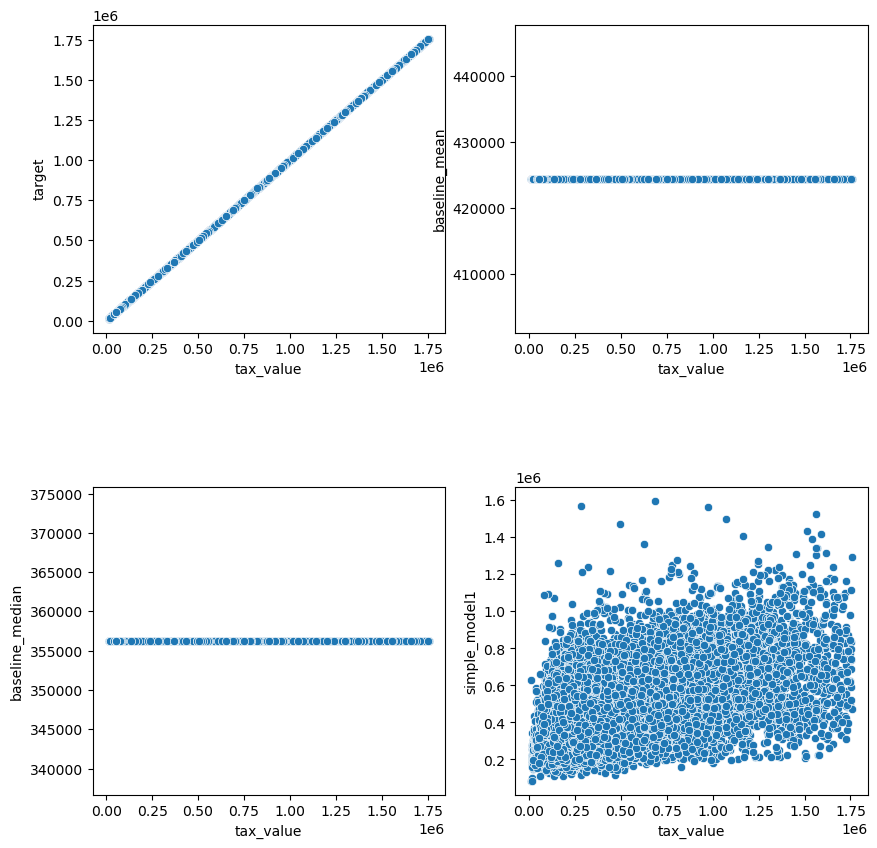

In [370]:
plt.figure(figsize=(10,10))
n = 221
for i in predictions.columns:
    
    plt.subplot(n)
    evaluate.plot_residuals(y_train,predictions[i])
    n+=1
    #plt.show()
plt.subplots_adjust(hspace=.5)    
plt.show()




In [262]:
predictions.columns

Index(['target', 'baseline_mean', 'baseline_median', 'simple_model2'], dtype='object')

In [57]:
def measure_performance(df):
    test_test = pd.DataFrame()
    for i in df.columns:
        test_test = test_test.append(evaluate.regression_errors(df['target'], df[i], df=True, features=4), ignore_index=True)
        #test_test['Model'] = predictions.columns[i]
        #test_test.set_index(predictions.columns[i], inplace=True)


    test_test['Model'] = np.array(df.columns)
    test_test.set_index('Model', inplace=True)
    return test_test



In [258]:
''' 
making models for each county
'''

# la county
# fit data to simple regression
lm.fit(la_x_train, la_y_train)

# make predictions
la_simple_model = lm.predict(la_x_train)

# orange county
# fit data to simple regression
lm.fit(or_x_train, or_y_train)

# make predictions
or_simple_model = lm.predict(or_x_train)

# la county
# fit data to simple regression
lm.fit(vent_x_train, vent_y_train)

# make predictions
vent_simple_model = lm.predict(vent_x_train)


In [270]:
'''
running the initial set of models through the function which will create our initial dataframe
holding performance measures for each model
'''
comparison_df = measure_performance(predictions)

In [272]:
''' 
appending to the performance measure recording dataframe, our new models' performance
'''
comparison_df = comparison_df.append(evaluate.regression_errors(la_y_train, la_simple_model, df=True, features = 4), ignore_index=True)
comparison_df = comparison_df.append(evaluate.regression_errors(or_y_train, or_simple_model, df=True, features = 4), ignore_index=True)
comparison_df = comparison_df.append(evaluate.regression_errors(vent_y_train, vent_simple_model, df=True, features = 4), ignore_index=True)

In [274]:
'''
replacing the index with the name of the models in our performance measure recording dataframe
'''

model_list = ['target', 'baseline_mean', 'baseline_median', 
              'simple_model', 'la_simple_model', 'or_simple_model', 'vent_simple_model']
comparison_df['Model'] = model_list
comparison_df.set_index('Model', inplace=True)

,ESS,SSE,TSS,MSE,RMSE,R^2,AdjR^2
Model,,,,,,,
target,3.571283e+15,0.000000e+00,3.571283e+15,0.000000e+00,0.000,1.000,1.000
baseline_mean,4.000000e-03,3.571283e+15,3.571283e+15,1.255990e+11,354399.535,-0.000,-0.000
baseline_median,1.889140e+14,3.760197e+15,3.949111e+15,1.322430e+11,363652.278,-0.053,-0.053
simple_model,1.242862e+15,2.328421e+15,3.571283e+15,8.188862e+10,286161.880,0.348,0.348
la_simple_model,6.226699e+14,1.600690e+15,2.223360e+15,8.717407e+10,295252.549,0.280,0.280
or_simple_model,4.593590e+14,5.603759e+14,1.019735e+15,7.320391e+10,270562.203,0.450,0.450
vent_simple_model,1.229724e+14,1.094109e+14,2.323833e+14,4.530472e+10,212849.056,0.529,0.528


### Those models performed pretty poorly. Baseline is terrible, regardless of it being the mean version or median version. The simple model worked better but was similarly awful. 

- time to work on tossing more outliers

In [293]:
df.columns

Index(['tax_value', 'bedrooms', 'baths', 'sq_feet', 'fips'], dtype='object')

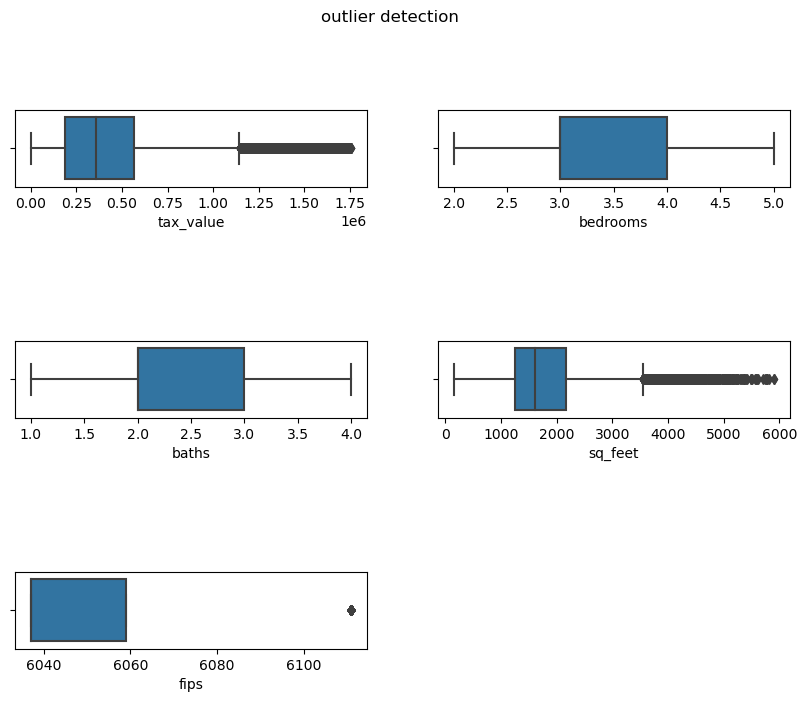

In [372]:
plt.figure(figsize=(10,10))

n=1
for i in df.columns:
    #n = 1
    plt.subplot(4,2,n)
    sns.boxplot(x = df[i])
    n +=1
    
plt.subplots_adjust(hspace=2)   
plt.suptitle('outlier detection')
plt.show()

### Messing with boolean masks to better handle outlier observations

In [345]:
48627/52500

0.9262285714285714

In [344]:
df.count()

tax_value    48627
bedrooms     48627
baths        48627
sq_feet      48627
fips         48627
dtype: int64

In [123]:
(df['tax_value'].max())*.88

1757580.8800000001

In [127]:
df[bool2].count()/(df.count())*100

tax_value    0.83701
bedrooms     0.83701
baths        0.83701
sq_feet      0.83701
fips         0.83701
dtype: float64

In [148]:
df[df.baths <= 4].count()

tax_value    49904
bedrooms     49904
baths        49904
sq_feet      49904
fips         49904
dtype: int64

In [149]:
bathroom_bool = df['baths'] <= 4
df[bool2].count()

tax_value    49904
bedrooms     49904
baths        49904
sq_feet      49904
fips         49904
dtype: int64

In [150]:
high_bed_bool = df['bedrooms'] <= 5 
low_bed_bool  = df['bedrooms'] > 1
tax_bool = df['tax_value'] < 1757580
bathroom_bool = df['baths'] <= 4

<AxesSubplot:xlabel='bedrooms'>

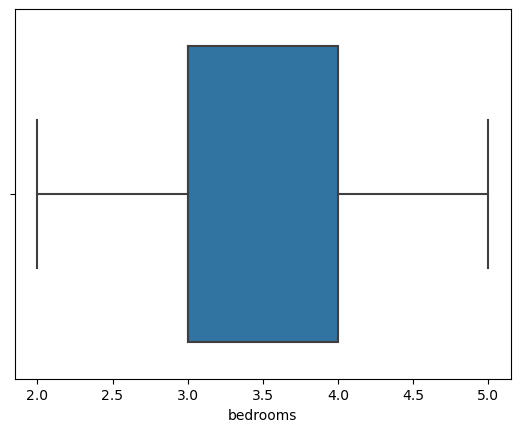

In [105]:
sns.boxplot(x = better_df['bedrooms'])

In [181]:
a.concat(b)

AttributeError: 'DataFrame' object has no attribute 'concat'

In [184]:
comparison_df = pd.concat([a, b], axis=0)

In [350]:
comparison_df

,ESS,SSE,TSS,MSE,RMSE,R^2,AdjR^2
Model,,,,,,,
target,2.795146e+15,0.000000e+00,2.795146e+15,0.000000e+00,0.000,1.000,1.000
baseline_mean,3.000000e-03,2.795146e+15,2.795146e+15,1.026269e+11,320354.303,0.000,-0.000
baseline_median,1.263887e+14,2.921534e+15,3.047923e+15,1.072674e+11,327516.994,-0.045,-0.045
simple_model,8.390040e+14,1.956142e+15,2.795146e+15,7.182191e+10,267996.108,0.300,0.300
la_simple_model,6.226699e+14,1.600690e+15,2.223360e+15,8.717407e+10,295252.549,0.280,0.280
or_simple_model,4.593590e+14,5.603759e+14,1.019735e+15,7.320391e+10,270562.203,0.450,0.450
vent_simple_model,1.229724e+14,1.094109e+14,2.323833e+14,4.530472e+10,212849.056,0.529,0.528


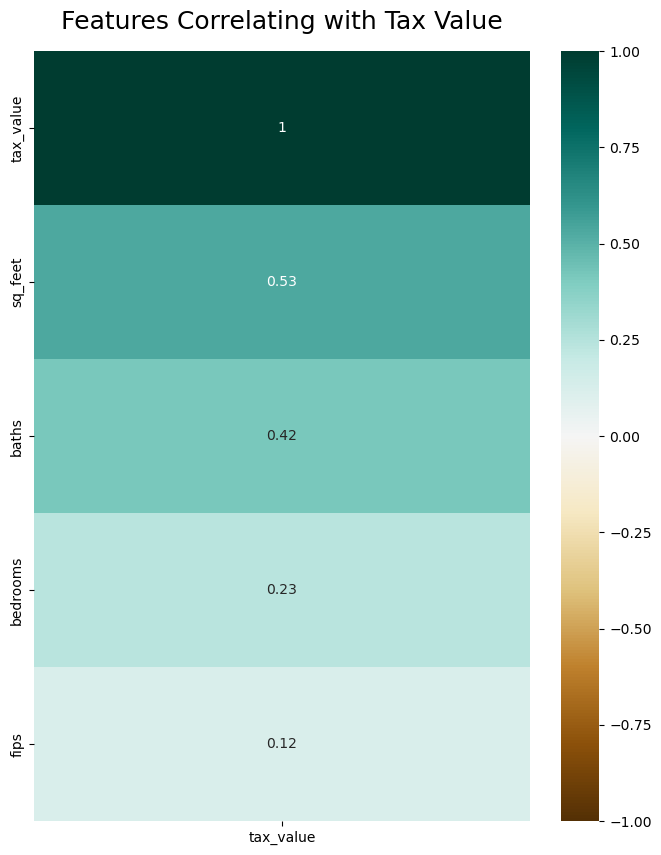

In [244]:
# sets size of the vizualization product
plt.figure(figsize=(8,10))

# creates a vertical heat map, correlating values in dataframe with a feature in the dataframe 
# (the target value to be predicted)
heatmap = sns.heatmap(df.corr()[['tax_value']].sort_values(by='tax_value', ascending = False), vmin=-1, vmax=1, annot=True,cmap='BrBG')

# title information
heatmap.set_title('Features Correlating with Tax Value', fontdict={'fontsize':18}, pad=16);

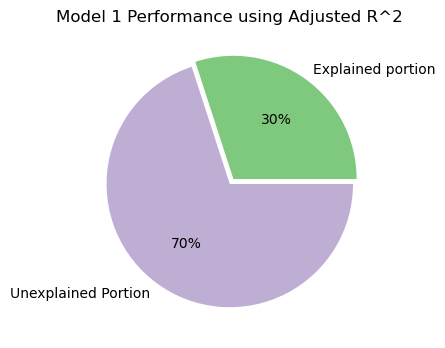

In [352]:
'''
Pie chart for Model 1
'''

labels = ['Explained portion', 'Unexplained Portion']
values = [comparison_df['AdjR^2']['simple_model'],(1-comparison_df['AdjR^2']['simple_model'])]
explode = [0.05, 0]
palette_color = sns.color_palette('Accent')

#setting title information
plt.title('Model 1 Performance using Adjusted R^2')

#creating pie with variables set above
pie1 = plt.pie(values, labels=labels, colors = palette_color, explode = explode, autopct='%.0f%%')

plt.show()

In [ ]:
'''
Pie charts for County Specific Models
'''

labels = ['Explained portion', 'Unexplained Portion']
values = [comparison_df['AdjR^2']['simple_model'],(1-comparison_df['AdjR^2']['simple_model'])]
explode = [0.05, 0]
palette_color = sns.color_palette('Accent')

#setting title information
plt.title('Model 1 Performance')

#creating pie with variables set above
plt.pie(values, labels=labels, colors = palette_color, explode = explode, autopct='%.0f%%')

plt.show()